# Notebook Title: MovieLens Small Dataset Analysis with NeuMF Model
Author: Anurak Yutthanawa

### Hypothesis
This notebook explores the hypothesis:
"User and movie embeddings learned through a Neural Collaborative Filtering (NeuMF) model can accurately predict user ratings for movies in the MovieLens small dataset."

### Setup and Libraries

In [1]:
# Required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.model_selection import train_test_split
from zipfile import ZipFile
from io import BytesIO
from urllib.request import urlopen

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Data Visualize

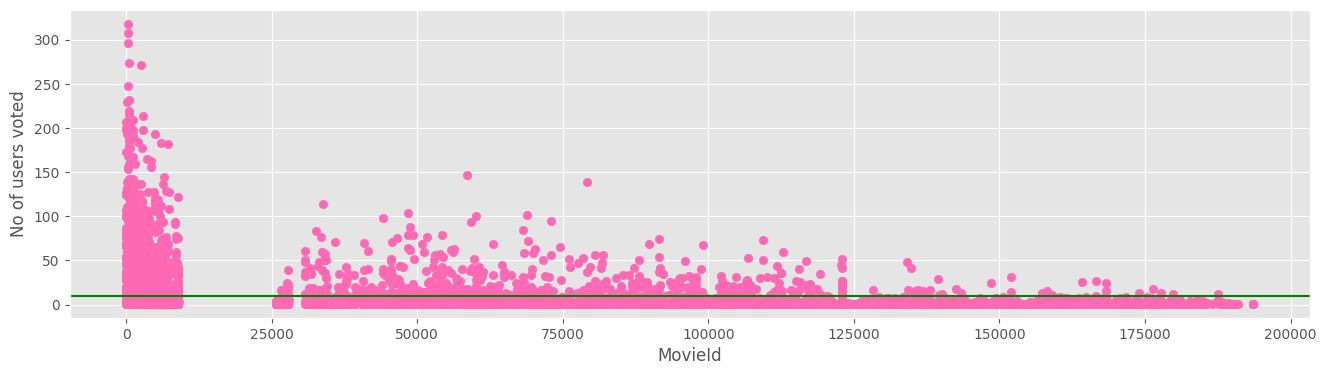

In [ ]:
movies = pd.read_csv("movielens-small/movies.csv")
ratings = pd.read_csv("movielens-small/ratings.csv")
movies.head()
ratings.head()

ratings = ratings.groupby(['movieId', 'userId']).agg({'rating': 'mean'}).reset_index()
final_dataset = ratings.pivot(index="movieId", columns="userId", values="rating")
final_dataset.fillna(0, inplace=True)

no_user_voted = ratings.groupby("movieId")['rating'].agg('count')
no_movies_voted = ratings.groupby("userId")['rating'].agg('count')

plt.style.use("ggplot")
fig,axes = plt.subplots(1,1, figsize=(16,4))
plt.scatter(no_user_voted.index, no_user_voted, color="hotpink")
plt.axhline(y=10, color='green')
plt.xlabel("MovieId")
plt.ylabel("No of users voted")
plt.show()

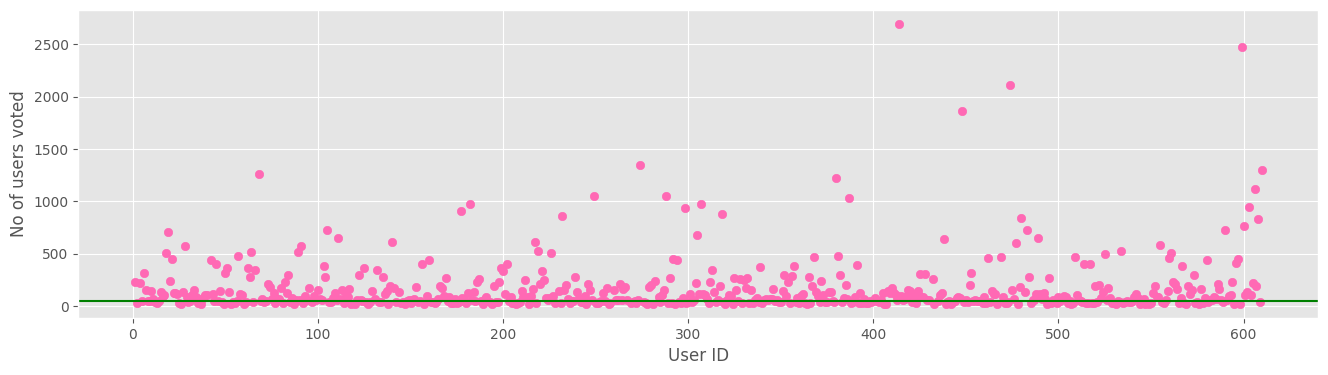

In [9]:
final_dataset = final_dataset.loc[no_user_voted[no_user_voted > 10].index, :]

plt.style.use("ggplot")
fig,axes = plt.subplots(1,1, figsize=(16,4))
plt.scatter(no_movies_voted.index, no_movies_voted, color="hotpink")
plt.axhline(y=50, color='green')
plt.xlabel("User ID")
plt.ylabel("No of users voted")
plt.show()

### Loading and Preprocessing the MovieLens Dataset

In [ ]:
# Read the ratings file
ratings_df = pd.read_csv("movielens-small/ratings.csv")
ratings_df.head()

,userId,movieId,rating,timestamp
0,1.0,1.0,4.0,964982703
1,1.0,3.0,4.0,964981247
2,1.0,6.0,4.0,964982224
3,1.0,47.0,5.0,964983815
4,1.0,50.0,5.0,964982931


Description: The MovieLens small dataset contains user ratings for movies. We'll preprocess the data by encoding user IDs and movie IDs and normalizing the ratings for better training.

### Encoding User and Movie IDs

In [3]:
# Encode users and movies
user_ids = ratings_df["userId"].unique().tolist()
user2user_encoded = {x: i for i, x in enumerate(user_ids)}
userencoded2user = {i: x for i, x in enumerate(user_ids)}

movie_ids = ratings_df["movieId"].unique().tolist()
movie2movie_encoded = {x: i for i, x in enumerate(movie_ids)}
movie_encoded2movie = {i: x for i, x in enumerate(movie_ids)}

ratings_df["user"] = ratings_df["userId"].map(user2user_encoded)
ratings_df["movie"] = ratings_df["movieId"].map(movie2movie_encoded)

# Dataset summary
num_users = len(user2user_encoded)
num_movies = len(movie_encoded2movie)
ratings_df["rating"] = ratings_df["rating"].values.astype(float)

min_rating = min(ratings_df["rating"])
max_rating = max(ratings_df["rating"])

print(f"Number of users: {num_users}, Number of Movies: {num_movies}, Min rating: {min_rating}, Max rating: {max_rating}")

Number of users: 591, Number of Movies: 9724, Min rating: -8.0, Max rating: 99.0


### Data Splitting and Normalization

In [4]:
# Shuffle and normalize data
df = ratings_df.sample(frac=1, random_state=42)
x = df[["user", "movie"]].values
y = df["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Split into training and validation sets
train_indices = int(0.9 * df.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:],
)

### NeuMF Model Definition

In [5]:
class NeuMF(nn.Module):
    def __init__(self, num_users, num_movies, embedding_size, hidden_size):
        super(NeuMF, self).__init__()
        self.user_embedding = nn.Embedding(num_users, embedding_size)
        self.movie_embedding = nn.Embedding(num_movies, embedding_size)
        self.user_bias = nn.Embedding(num_users, 1)
        self.movie_bias = nn.Embedding(num_movies, 1)
        self.gmf = nn.Linear(embedding_size, 1)
        self.mlp = nn.Sequential(
            nn.Linear(2 * embedding_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, hidden_size),
            nn.BatchNorm1d(hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(hidden_size, 1)
        )
        self.fc_final = nn.Linear(2, 1)

    def forward(self, user_input, movie_input):
        user_embed = self.user_embedding(user_input)
        movie_embed = self.movie_embedding(movie_input)
        user_bias = self.user_bias(user_input).squeeze()
        movie_bias = self.movie_bias(movie_input).squeeze()
        gmf_output = torch.mul(user_embed, movie_embed)
        gmf_output = self.gmf(gmf_output)
        mlp_input = torch.cat([user_embed, movie_embed], dim=1)
        mlp_output = self.mlp(mlp_input)
        final_output = torch.cat([gmf_output, mlp_output], dim=1)
        raw_prediction = self.fc_final(final_output).squeeze()
        raw_prediction += user_bias + movie_bias
        prediction = torch.sigmoid(raw_prediction)
        return prediction

### Model Training and Validation

In [6]:
# Prepare DataLoader
train_data = TensorDataset(torch.tensor(x_train[:, 0]), torch.tensor(x_train[:, 1]), torch.tensor(y_train))
val_data = TensorDataset(torch.tensor(x_val[:, 0]), torch.tensor(x_val[:, 1]), torch.tensor(y_val))

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)

# Model initialization
embedding_size = 50
hidden_sizes = 64
neumf_model = NeuMF(num_users, num_movies, embedding_size, hidden_sizes).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(neumf_model.parameters(), lr=0.001)
num_epochs = 20

# Training Loop
for epoch in range(num_epochs):
    neumf_model.train()
    for user_batch, item_batch, label_batch in train_loader:
        optimizer.zero_grad()
        predictions = neumf_model(user_batch, item_batch)
        loss = criterion(predictions, label_batch.float())
        loss.backward()
        optimizer.step()

    neumf_model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for user_batch, item_batch, label_batch in val_loader:
            predictions = neumf_model(user_batch, item_batch)
            val_loss += criterion(predictions, label_batch.float())

    print(f"Epoch {epoch + 1}/{num_epochs}, Training Loss: {loss.item()}, Validation Loss: {val_loss.item()}")

Epoch 1/20, Training Loss: 0.008878957480192184, Validation Loss: 1.4783803224563599
Epoch 2/20, Training Loss: 0.019984371960163116, Validation Loss: 1.3677936792373657
Epoch 3/20, Training Loss: 0.015158100053668022, Validation Loss: 1.1629348993301392
Epoch 4/20, Training Loss: 0.0047679925337433815, Validation Loss: 0.8460090160369873
Epoch 5/20, Training Loss: 0.016696110367774963, Validation Loss: 0.6388716101646423
Epoch 6/20, Training Loss: 0.002037197584286332, Validation Loss: 0.5143994688987732
Epoch 7/20, Training Loss: 0.001117458799853921, Validation Loss: 0.43529012799263
Epoch 8/20, Training Loss: 0.008532256819307804, Validation Loss: 0.3915196657180786
Epoch 9/20, Training Loss: 0.0010742583544924855, Validation Loss: 0.3642721474170685
Epoch 10/20, Training Loss: 0.003870860207825899, Validation Loss: 0.3442484736442566
Epoch 11/20, Training Loss: 0.0011618629796430469, Validation Loss: 0.34739601612091064
Epoch 12/20, Training Loss: 0.0010658901883289218, Validation

### Save Model

In [ ]:
torch.save(neumf_model, 'final_neumf_model.pth')

### Prediction Example

In [ ]:
# Example prediction
user_id = torch.tensor([1])
movie_id = torch.tensor([16])

with torch.no_grad():
    prediction = neumf_model(user_id, movie_id)

original_scale_prediction = prediction.item() * (max_rating - min_rating) + min_rating

print(f'Predicted Rating: {original_scale_prediction}')

Predicted Rating: 0.12978217005729675
